Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.5min finished


Accuracy for description feature:


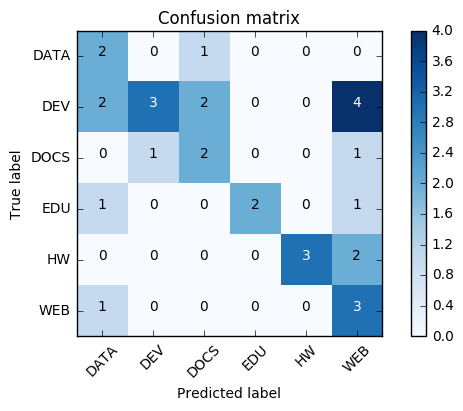

0.483870967742
['homework', 'app', 'application', 'notes', 'submission']
['HW' 'DEV' 'DEV' 'WEB' 'DEV']


In [1]:
"""Fit SGDClassifier on a Tf-Idf matrix, evaluate it against the validation set
and plot the most and least important words per category"""
%load_ext autoreload
%autoreload 2
from app.evaluation import eval_classifier
from app.training import get_best_text_pipeline, get_undersample_df
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy

train_df = pd.read_csv("data/processed_data.csv")
train_df = get_undersample_df(train_df)
val_df = pd.DataFrame.from_csv("data/validation_data.csv")
y_train = train_df.pop("label")
y_val = val_df.pop("label")
examples = ["homework", "app", "application", "notes", "submission"]

le = LabelEncoder().fit(y_train)
classes = le.classes_

for text_feature in ["description"]:#, "readme"]:  
    train_df[text_feature].fillna("", inplace=True)
    val_df[text_feature].fillna("", inplace=True)
    X_train = train_df[text_feature].values
    X_val = val_df[text_feature].values

    ppl = find_best_text_pipeline(X_train, y_train)
    print "Accuracy for {} feature:".format(text_feature)
    acc = eval_classifier(ppl, X_val, y_val, le.classes_)
    print acc
    print examples
    print ppl.predict(examples)

In [2]:
val_df = pd.DataFrame.from_csv("data/validation_data.csv")
val_df.fillna("description", inplace=True)
for i, row in val_df.iterrows():
    true = row["label"]
    pred = ppl.predict([row["description"]])
    if true != pred:
        print "{}: label: {}\tpredicted: {} for\n{}".format(row["repository"], true, pred, row["description"])

hpi-swt2-exercise/java-tdd-challenge: label: EDU	predicted: ['DATA'] for
Fork this repository to learn TDD in Java
vhf/free-programming-books: label: DATA	predicted: ['DOCS'] for
:books: Freely available programming books
d3/d3: label: DEV	predicted: ['DATA'] for
Bring data to life with SVG, Canvas and HTML. :bar_chart::chart_with_upwards_trend::tada:
carlosmn/CoMa-II: label: HW	predicted: ['WEB'] for
description
git/git-scm.com: label: DEV	predicted: ['WEB'] for
The git-scm.com website. Note that this repository is only for the website; issues with git itself should go to https://git-scm.com/community.
PowerDNS/pdns: label: DEV	predicted: ['WEB'] for
PowerDNS
cmrberry/cs6300-git-practice: label: HW	predicted: ['WEB'] for
description
mongodb/docs: label: DOCS	predicted: ['WEB'] for
The MongoDB Documentation Project Source.
sindresorhus/eslint-config-xo: label: DEV	predicted: ['WEB'] for
ESLint shareable config for XO
e-books/backbone.en.douceur: label: EDU	predicted: ['WEB'] for
le gro

In [3]:
from operator import itemgetter

vect = ppl.named_steps["vect"]
clf = ppl.named_steps["clf"]
tvec = clf.coef_
output = []
for i in range(len(tvec)):
    output.append(classes[i])
    coefs = sorted(zip(tvec[i], vect.get_feature_names()), key=itemgetter(0), reverse=True)
    n = 20
    topn = zip(coefs[:n], coefs[:-(n+1):-1])
    output.append("{:>15}    {: >20}".format("Positive Words", "Negative Words"))
    for (cp, fnp), (cn, fnn) in topn:
        output.append(u"{:0.4f}{: >15}    {:0.4f}{: >15}".format(
            cp, fnp, cn, fnn
            )
    )
    output.append("--------------------")
print "\n".join(output)

DATA
 Positive Words          Negative Words
4.5454        dataset    -3.5198          curat
4.4541           data    -3.3275         websit
3.7519             us    -3.2966         materi
3.5394        countri    -3.2948          upcom
3.4947       catalogu    -3.2948      hackathon
3.4947      exoplanet    -3.1064        footbal
3.4631           name    -3.1063           blog
3.4136          price    -2.6902          spice
3.2948            639    -2.6902        rethink
3.2553       metadata    -2.5849           tool
3.2390          index    -2.5200          cours
3.2304     datapackag    -2.4645        resourc
2.8926            iso    -2.4468       document
2.7931           unit    -2.3884          sourc
2.7893         global    -2.3396          solut
2.7828          natur    -2.3396       homework
2.6872             as    -2.3298           我的博客
2.6724          locat    -2.3298      北邮人常用网址导航
2.4636        classif    -2.3298         我的前端博客
2.4337         govern    -2.3298 siberiawol